In [1]:
# Import all Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

url = 'https://github.com/sehyunlee217/MIE368_proj/blob/main/watson_healthcare_modified.csv?raw=true'

In [3]:
# Read data
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Shift', 'StandardHours', 'Over18'], inplace=True)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Map target variable in training and testing data
train_df['Attrition'] = train_df['Attrition'].map({"Yes": 1, "No": 0})
test_df['Attrition'] = test_df['Attrition'].map({"Yes": 1, "No": 0})

# Convert categorical to numerical for both datasets
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1})
train_df['OverTime'] = train_df['OverTime'].map({'No': 0, 'Yes': 1})
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
test_df['OverTime'] = test_df['OverTime'].map({'No': 0, 'Yes': 1})
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

# Apply one-hot encoding to nominal variables
cols_nom = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']

encoder = OneHotEncoder()

# Fit on training data
encoder.fit(train_df[cols_nom])

# Transform both training and test datasets
train_encoded = pd.DataFrame(encoder.transform(train_df[cols_nom]).toarray(),
                             columns=encoder.get_feature_names_out())
test_encoded = pd.DataFrame(encoder.transform(test_df[cols_nom]).toarray(),
                            columns=encoder.get_feature_names_out())

# Reset index and merge encoded columns back
train_encoded.reset_index(drop=True, inplace=True)
test_encoded.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df.drop(columns=cols_nom, inplace=True)
test_df.drop(columns=cols_nom, inplace=True)

train_df = pd.concat([train_df, train_encoded], axis=1)
test_df = pd.concat([test_df, test_encoded], axis=1)

# apply SMOTE on X_train
X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']
X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(len(X_train_resampled.columns))
print(len(X_test.columns))


42
42


In [4]:
# fitting Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG, display

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

print(len(X_train_resampled.columns))
print(len(X_test.columns))

# Define the hyperparameter distributions
param_dist = {
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 50)
}

# Initialize the CART model
CART = DecisionTreeClassifier()

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=CART,
    param_distributions=param_dist,
    n_iter=500,
    cv=5,
    verbose=2,
    random_state=1,
    n_jobs=-1,
    return_train_score=True,
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

best_CART= random_search.best_estimator_


42
42
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=1,

In [5]:
#  SVM
# Import classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the SVM instance
svm = SVC(probability=True)

# Run Grid Search with parameters to find most optimial combination of parameters

# Pipeline with scaling and SVM
pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

# Define hyperparameter grid
param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.1, 1]}

# GridSearch for best parameters
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_resampled, y_train_resampled)
svm = grid.best_estimator_

In [6]:

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd

print(len(X_train_resampled.columns))
print(len(X_test.columns))

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

bagging_param_grid = {
    'n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 7, 10],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}


rf_model = RandomForestClassifier(random_state=42)
bagging_base = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),random_state=42)

rf_grid_search = GridSearchCV(estimator=rf_model,param_grid=rf_param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

rf_model = rf_grid_search.best_estimator_

bagging_grid_search = GridSearchCV(estimator=bagging_base,param_grid=bagging_param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)
bagging_grid_search.fit(X_train_resampled, y_train_resampled)

bagging_model = bagging_grid_search.best_estimator_

42
42
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [7]:
import xgboost as x
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb = x.XGBClassifier()
xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
%pip install catboost
%pip install optuna
import catboost
from catboost import CatBoostClassifier, Pool

# Catboost works better without one-hot encoding
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Shift', 'StandardHours', 'Over18'], inplace=True)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Map target variable in training and testing data
train_df['Attrition'] = train_df['Attrition'].map({"Yes": 1, "No": 0})
test_df['Attrition'] = test_df['Attrition'].map({"Yes": 1, "No": 0})

# Convert categorical to numerical for both datasets
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1})
train_df['OverTime'] = train_df['OverTime'].map({'No': 0, 'Yes': 1})
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
test_df['OverTime'] = test_df['OverTime'].map({'No': 0, 'Yes': 1})
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

# apply SMOTE on X_train
cat_X_train = train_df.drop(columns=['Attrition'])
cat_y_train = train_df['Attrition']
cat_X_test = test_df.drop(columns=['Attrition'])
cat_y_test = test_df['Attrition']

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='Logloss', verbose=True)

cat_model.fit(cat_X_train, 
              cat_y_train,
              cat_features=categorical_features,
              verbose=True
              )

cat_train_pool = catboost.Pool(cat_X_train, cat_y_train, cat_features=categorical_features)
cat_test_pool = catboost.Pool(cat_X_test, cat_y_test, cat_features=categorical_features)

# import catboost
# from catboost.utils import eval_metric
# import optuna
# from optuna.samplers import TPESampler

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
#         'depth': trial.suggest_int('depth', 1, 6),
#         'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
#         'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8)
#     }

#     model = catboost.CatBoostClassifier(**params, random_seed=42)
#     model.fit(cat_train_pool, verbose=False)
#     y_pred = model.predict(cat_test_pool)
#     return accuracy_score(y_pred, y_test)

# sampler = TPESampler(seed=123)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=20)

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=1, learning_rate=0.7111094911557769, boosting_type='Plain', max_ctr_complexity=8)

cat_model.fit(cat_X_train, 
              cat_y_train,
              cat_features=categorical_features,
              verbose=0
              )


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
0:	learn: 0.3201537	total: 56.9ms	remaining: 5.63s
1:	learn: 0.2578593	total: 58ms	remaining: 2.84s
2:	learn: 0.2410384	total: 59.2ms	remaining: 1.91s
3:	learn: 0.2270980	total: 60.1ms	remaining: 1.44s
4:	learn: 0.2080941	total: 61ms	remaining: 1.16s
5:	learn: 0.1873131	total: 61.8ms	remaining: 968ms
6:	learn: 0.1703477	total: 62.7ms	remaining: 833ms
7:	learn: 0.1604228	total: 63.5ms	remaining: 731ms
8:	learn: 0.1530673	total: 64.7ms	remaining: 654ms
9:	learn: 0.1492079	total: 65.6ms	remaining: 590ms
10:	learn: 0.1491936	total: 66.4ms	remaining: 538ms
11:	learn: 0.1441654	total: 67.4ms	remaining: 494ms
12:	learn: 0.1366099	total: 68.2ms	r

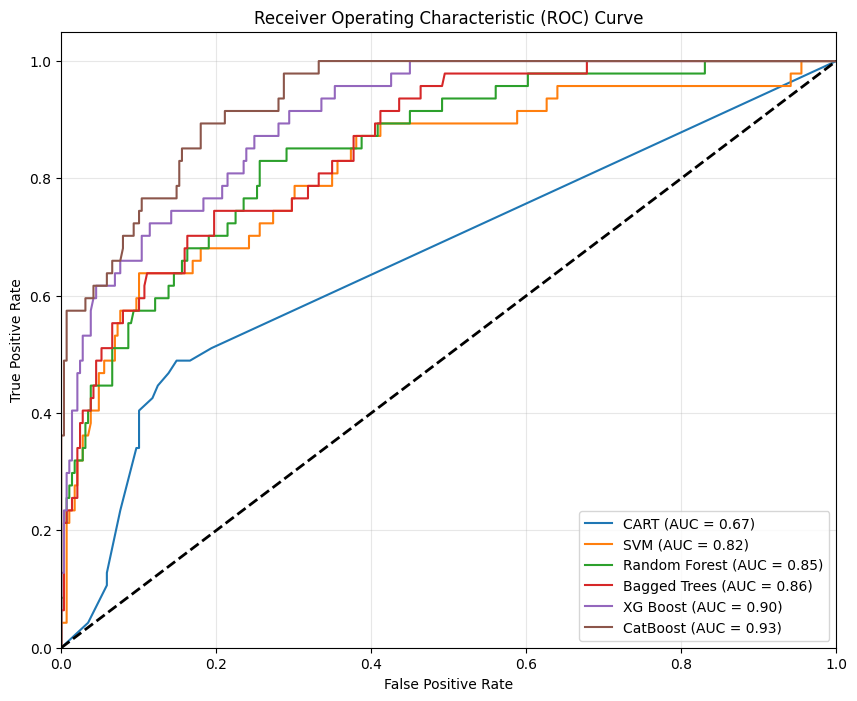

['CART', 'SVM', 'Random Forest', 'Bagged Trees', 'XG Boost']


In [36]:
from sklearn.metrics import precision_recall_fscore_support as prfs, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

def calculate_metrics(X_test, y_test, model):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate precision, recall, f1-score, and support
    metrics_values = prfs(y_test, y_pred)
    
    # Extract recall and f1-score for the positive class (class 1)
    recall = metrics_values[1][1]
    f1 = metrics_values[2][1]

    return recall, f1

def plot_combined_ROC(models, X_test, y_test, labels, cat_model, cat_X_test, cat_y_test):
    plt.figure(figsize=(10, 8))
    
    for model, label in zip(models, labels):
        # Get predicted probabilities for the positive class
        pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

    pred_proba = cat_model.predict_proba(cat_X_test)[:, 1]
    fpr, tpr, _ = roc_curve(cat_y_test, pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{'CatBoost'} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    recalls = []
    f1_scores = []
    model_names = []
    
    for model, label in zip(models, labels):
        recall, f1 = calculate_metrics(X_test, y_test, model)
        recalls.append(recall)
        f1_scores.append(f1)
        model_names.append(label)
    
    print(model_names)

    recall, f1 = calculate_metrics(cat_X_test, cat_y_test, cat_model)
    recalls.append(recall)
    f1_scores.append(f1)
    model_names.append("CatBoost")

    return recalls, f1_scores, model_names

# Example usage
models = [best_CART, svm, rf_model, bagging_model, xgb]
labels = ['CART', 'SVM', 'Random Forest', 'Bagged Trees', 'XG Boost']
recalls, f1_scores, models = plot_combined_ROC(models, X_test, y_test, labels, cat_model, cat_X_test, cat_y_test)

In [37]:
models

['CART', 'SVM', 'Random Forest', 'Bagged Trees', 'XG Boost', 'CatBoost']

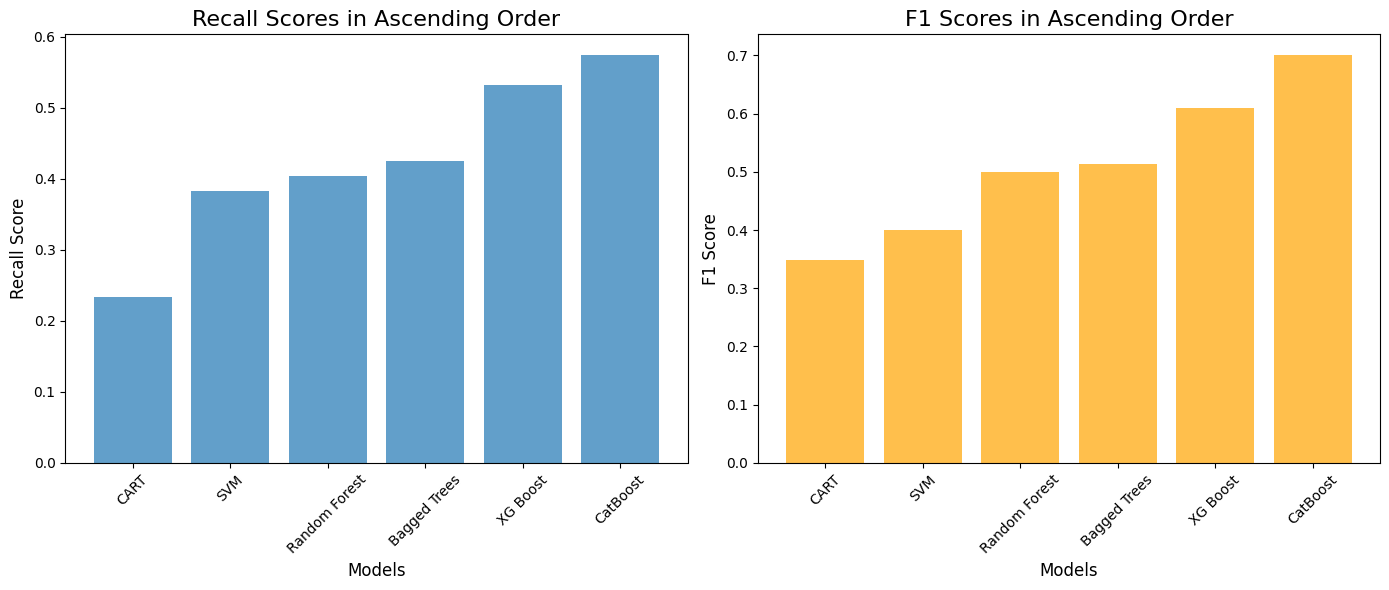

In [47]:
# Sort recalls and f1_scores in ascending order
sorted_recalls = sorted(recalls)
sorted_f1_scores = sorted(f1_scores)
model_names = ['CART', 'SVM', 'RF', 'Bagged Trees', 'CatBoost', 'XGBoost']

# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot recall histogram
ax1.bar(np.arange(len(sorted_recalls)), sorted_recalls, alpha=0.7)
ax1.set_title('Recall Scores in Ascending Order', fontsize=16)
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Recall Score', fontsize=12)
ax1.set_xticks(np.arange(len(sorted_recalls)))
ax1.set_xticklabels(models, rotation=45)

# Plot F1 score histogram
ax2.bar(np.arange(len(sorted_f1_scores)), sorted_f1_scores, color='orange', alpha=0.7)
ax2.set_title('F1 Scores in Ascending Order', fontsize=16)
ax2.set_xlabel('Models', fontsize=12)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_xticks(np.arange(len(sorted_f1_scores)))
ax2.set_xticklabels(models, rotation=45)

plt.tight_layout()